In [251]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import time
from scipy.signal import wiener

In [7]:
path = os.path.abspath("")
obj = 'car'
fileFolderPath = f'{path}\\..\\{obj}\\{obj}'
filePath = os.path.normpath(f'{fileFolderPath}.jpg')
print(filePath)

c:\Users\rss\uni\python-denoise\car\car.jpg


In [406]:
float_data = np.float32
uint_data = np.uint8

grey = True
image = mpimg.imread(filePath)

if (grey):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gaus = add_gaussian_noise(image, mean=15, std=55)
sap = add_salt_and_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05)
shot = add_shot_noise(image)
film = add_film_grain(image, intensity=0.15, grain_size=1)
anis = add_anisotropic_noise(image, intensity=0.5, direction=(1,2))
per = add_periodic_noise(image, frequency=22, amplitude=33)

noise_images = [gaus, sap, shot, film, anis, per]
names = ["gaus blur", "salt and pepper", "shot", "film grain", "anisotropic", "periodical"]

In [274]:
def show(images):
    rows = 2
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()
    for i, (image, name) in enumerate(zip(images, names)):
        axes[i].imshow(image, cmap="grey")
        axes[i].set_title(name, fontsize=12)
        axes[i].axis('off')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    #plt.savefig(f'{filePath}-comparison-plot.png', format='png', dpi=600)
    plt.show()


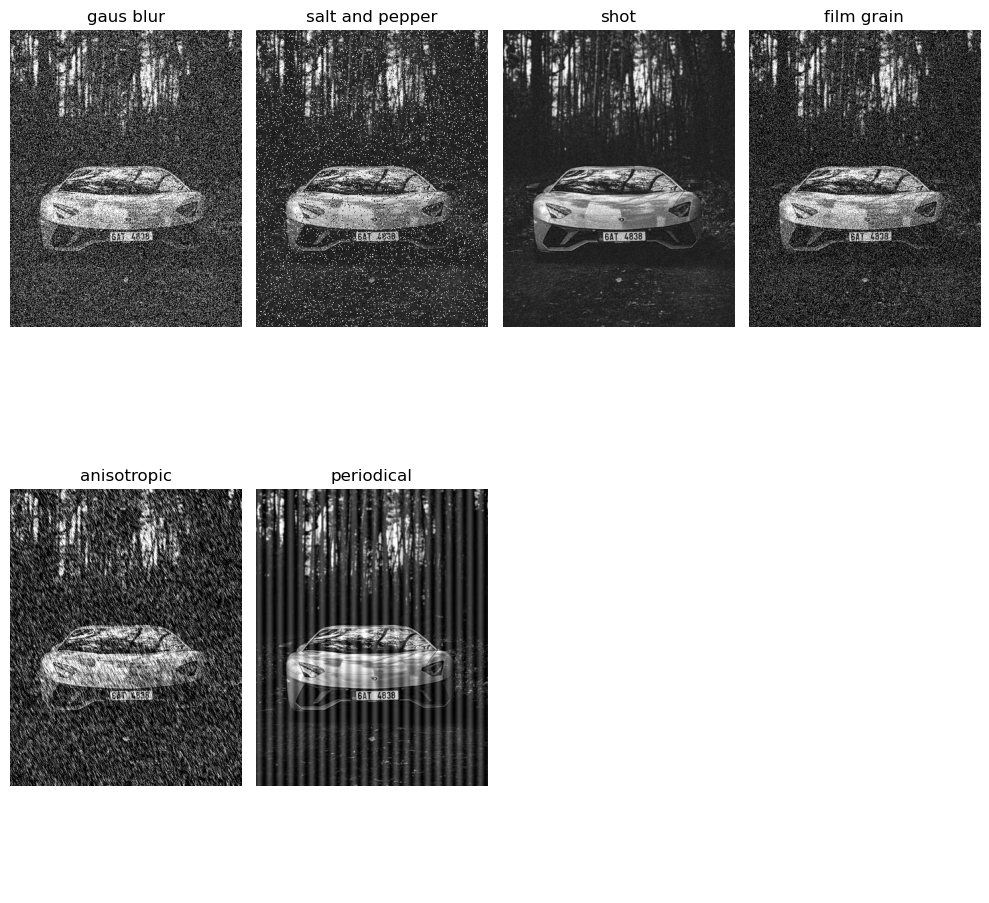

In [407]:
show(noise_images)

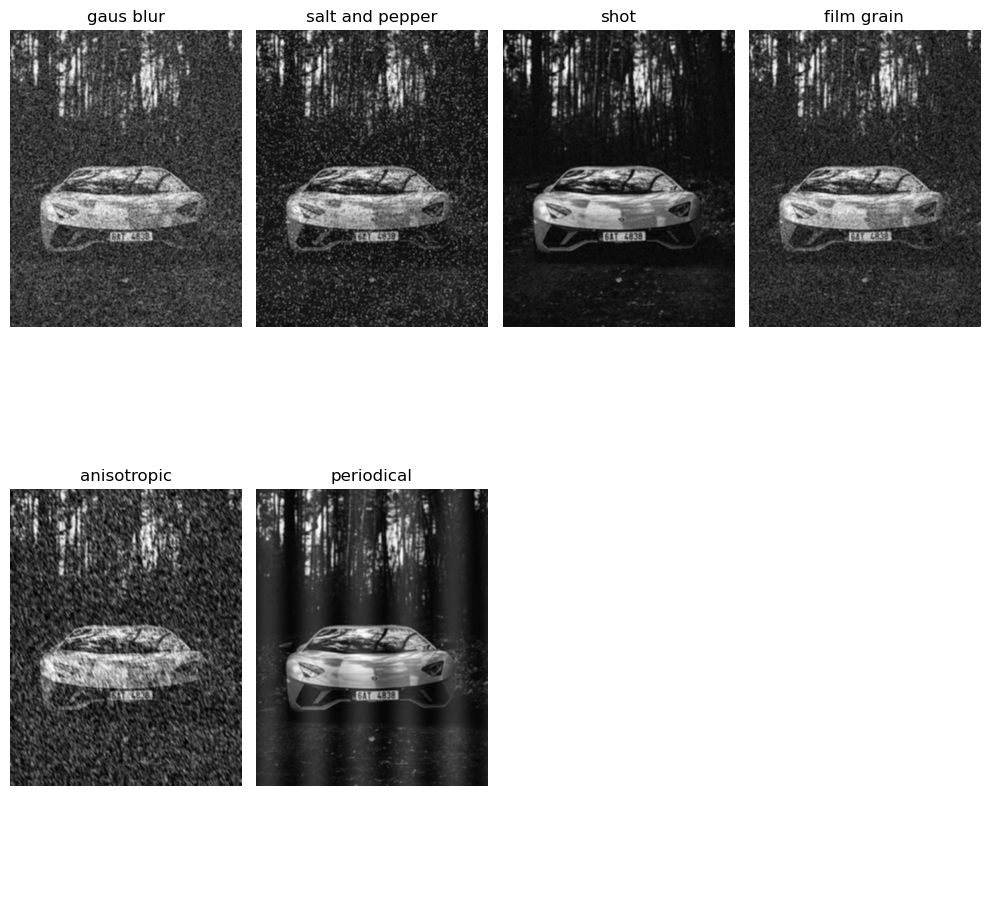

In [276]:
mean_filtered = [cv2.blur(x, (3, 3)) for x in noise_images]
show(mean_filtered)

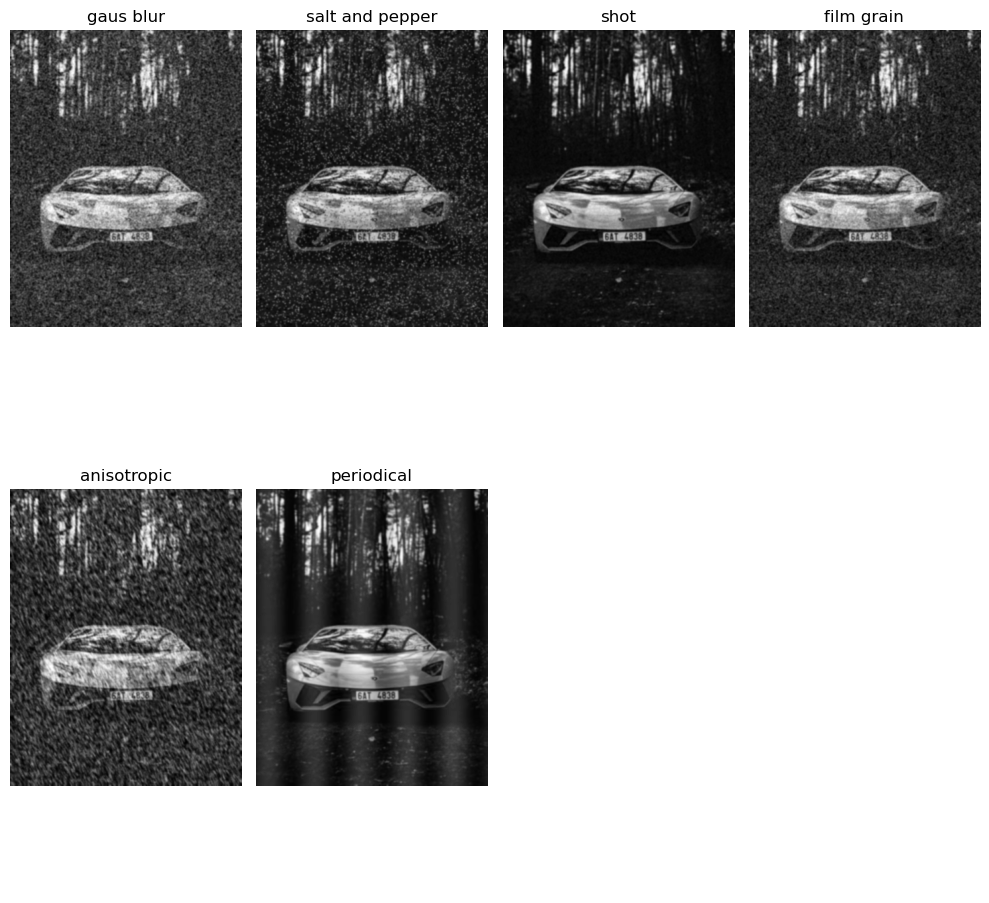

In [277]:
gaus_filtered = [cv2.GaussianBlur(x, (0, 0), 1) for x in noise_images]
show(gaus_filtered)

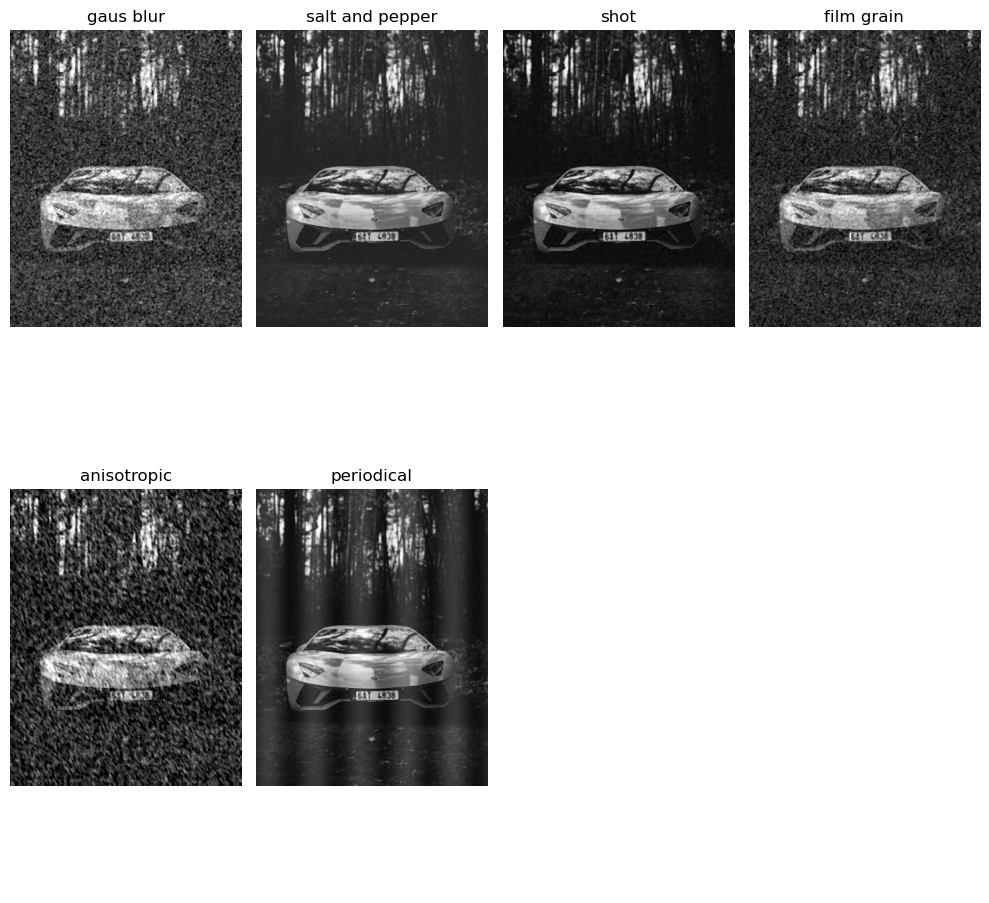

In [278]:
median_filtered = [cv2.medianBlur(x, 3) for x in noise_images]
show(median_filtered)

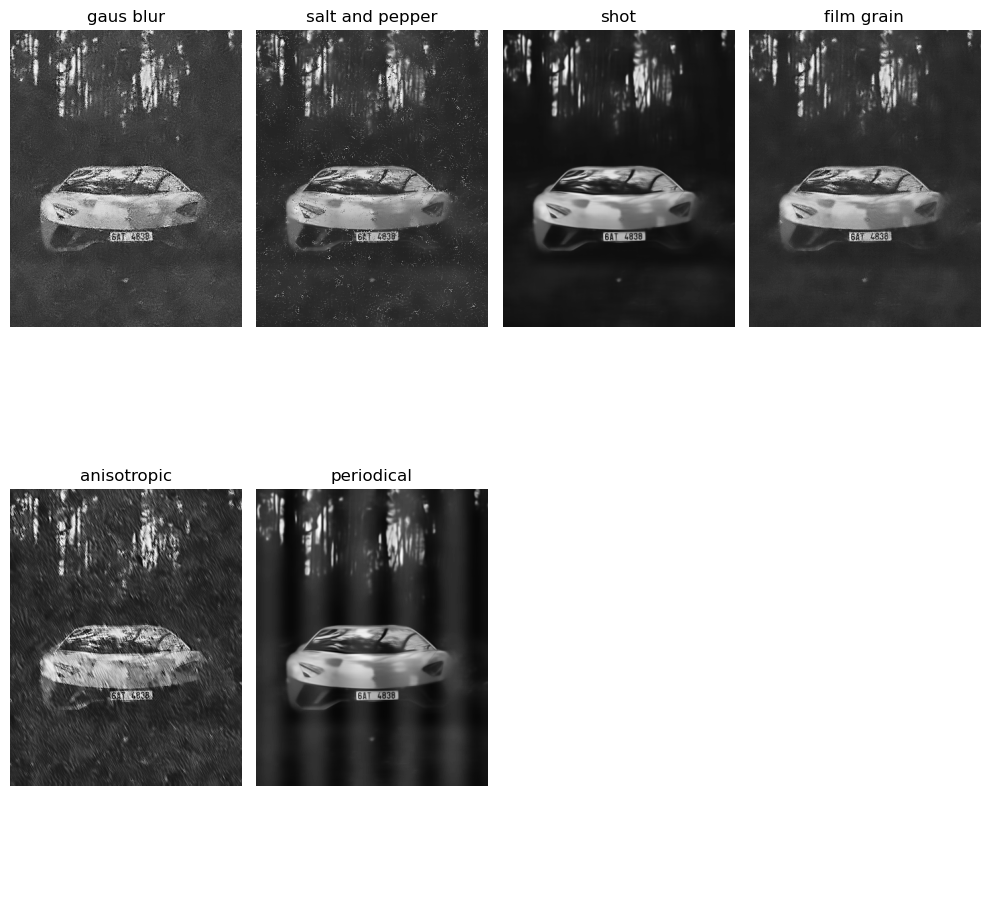

In [290]:
nlm_filtered = [nlm_denoise(x, h = 35, templateWindowSize = 7, searchWindowSize = 21) for x in noise_images]
show(nlm_filtered)

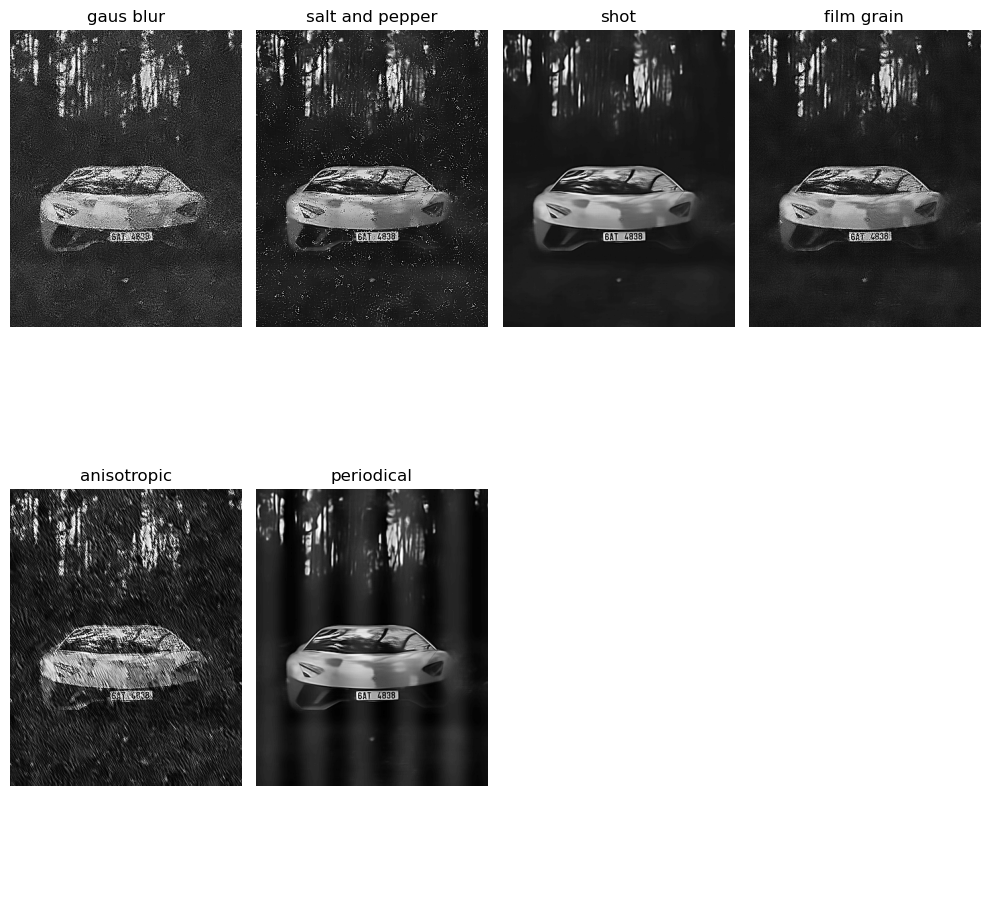

In [291]:
nlm_sharp_filtered = [sharpen(x) for x in nlm_filtered]
show(nlm_sharp_filtered)

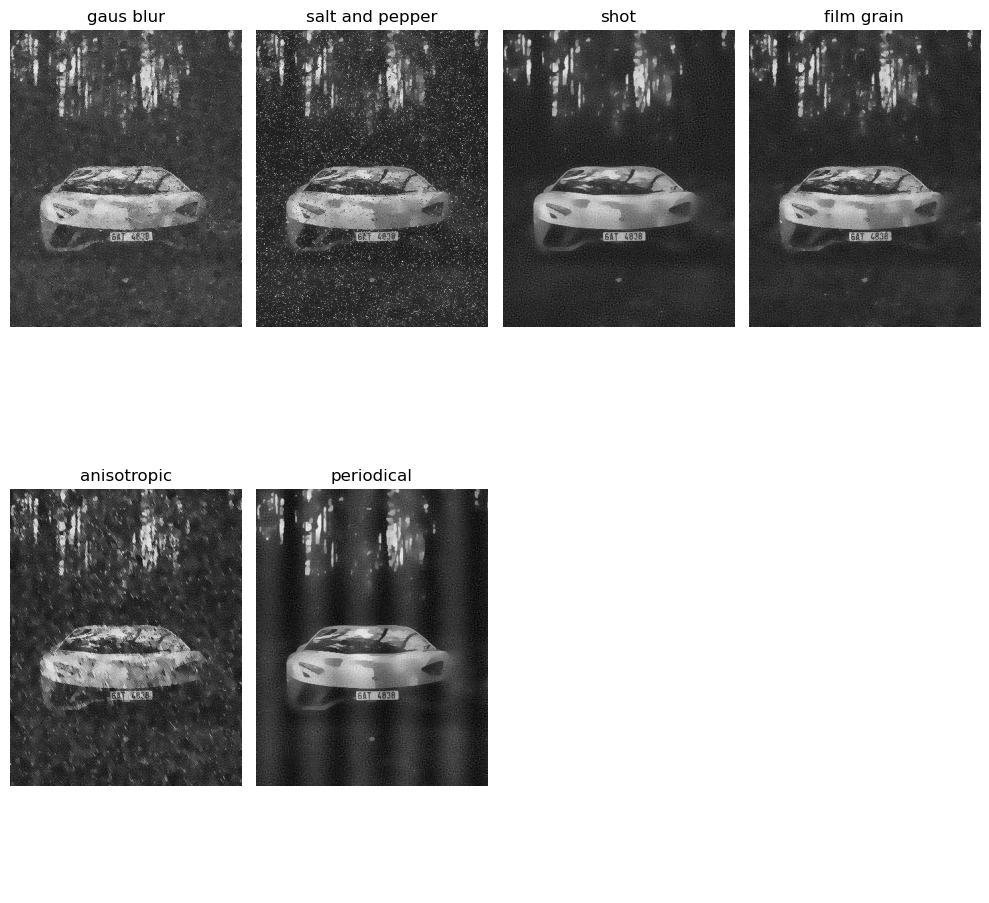

In [301]:
anis_filtered = [anis_denoise(x, iterations = 11, delta_t = 0.5, kappa = 15, kSize = 3) for x in noise_images]
show(anis_filtered)

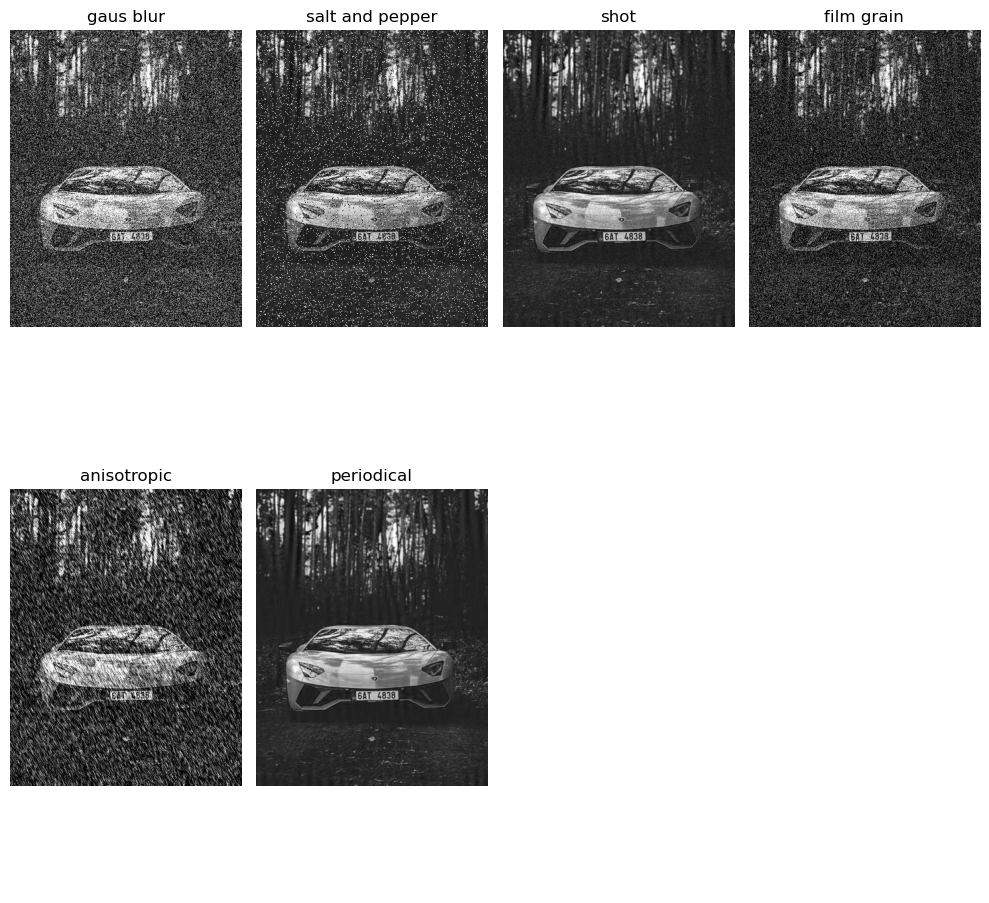

In [418]:
fft_filtered = [fft_denoise(x, k=5, l=5, frequency=32) for x in noise_images]
show(fft_filtered)

In [50]:
def add_gaussian_noise(image, mean=5, std=55):
    noise = np.random.normal(mean, std, image.shape).astype(float_data)
    noisy_image = cv2.add(image.astype(float_data), noise)
    return np.clip(noisy_image, 0, 255).astype(uint_data)

In [48]:
def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = image.copy()
    total_pixels = image.size
    num_salt = int(salt_prob * total_pixels)
    num_pepper = int(pepper_prob * total_pixels)

    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 255

    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 0

    return noisy_image

In [124]:
def add_shot_noise(image):
    image_float = image.astype(float_data) / 255.0

    # Apply Poisson noise by scaling up the image to avoid zero values
    noisy_image = np.random.poisson(image_float * 255.0) / 255.0

    # Convert the image back to the 0-255 range and uint8
    noisy_image = np.clip(noisy_image * 255, 0, 255).astype(uint_data)

    return noisy_image

In [68]:
def add_film_grain(image, intensity=0.3, grain_size=1):
    # Check if the image is grayscale or color
    if len(image.shape) == 2:  # Grayscale image
        rows, cols = image.shape
        noise = np.random.normal(0, intensity * 255, (rows, cols)).astype(float_data)
    elif len(image.shape) == 3:  # Color image
        rows, cols, _ = image.shape
        noise = np.random.normal(0, intensity * 255, (rows, cols, 1)).astype(float_data)
        noise = np.repeat(noise, 3, axis=2)

    # Create a grainy texture by resizing the noise to grain_size and back
    if grain_size > 1:
        small_noise = cv2.resize(noise, (cols // grain_size, rows // grain_size))
        noise = cv2.resize(small_noise, (cols, rows))

    # Add the grainy noise to the image
    noisy_image = cv2.add(image.astype(float_data), noise)

    # Clip the values to be in the valid range [0, 255] and convert back to uint8
    return np.clip(noisy_image, 0, 255).astype(uint_data)

In [212]:
def add_anisotropic_noise(image, intensity=0.5, direction=(1, 0)):
    # Create noise
    noise = np.random.normal(0, intensity * 255, image.shape[:2])

    # Apply an anisotropic blur to the noise using a directional kernel
    direction = np.array(direction) / np.linalg.norm(direction)  # Normalize direction
    kernel_size = int(max(image.shape[:2]) * 0.02)
    kernel_size = kernel_size if kernel_size % 2 == 1 else kernel_size + 1  # Ensure odd kernel size
    kernel = np.zeros((kernel_size, kernel_size), dtype=float_data)
    cv2.line(kernel, (kernel_size // 2, kernel_size // 2),
             (kernel_size // 2 + int(direction[0] * kernel_size // 2),
              kernel_size // 2 + int(direction[1] * kernel_size // 2)), 1, thickness=1)

    # Normalize kernel
    kernel /= np.sum(kernel)

    # Apply the anisotropic kernel to the noise
    anisotropic_noise = cv2.filter2D(noise, -1, kernel)

    # Repeat the noise across channels if image is in color
    if len(image.shape) == 3:  # Color image
        anisotropic_noise = np.repeat(anisotropic_noise[:, :, np.newaxis], 3, axis=2)

    # Add the anisotropic noise to the image
    noisy_image = cv2.add(image.astype(float_data), anisotropic_noise.astype(float_data))

    # Clip values to valid range and convert back to uint8
    return np.clip(noisy_image, 0, 255).astype(uint_data)

In [44]:
def add_periodic_noise(image, frequency=5, amplitude=20):
    # Check if the image is grayscale or color
    if len(image.shape) == 2:  # Grayscale image
        rows, cols = image.shape
    elif len(image.shape) == 3:  # Color image
        rows, cols, _ = image.shape  # Ignore the third channel dimension

    # Generate a sine wave pattern
    x = np.arange(0, cols)
    y = np.sin(2 * np.pi * frequency * x / cols) * amplitude
    y = np.tile(y, (rows, 1))

    # If the image is color, repeat the noise across all color channels
    if len(image.shape) == 3:  # Color image
        y = np.repeat(y[:, :, np.newaxis], 3, axis=2)

    # Add the periodic noise to the image
    noisy_image = cv2.add(image.astype(float_data), y.astype(float_data))

    # Clip the values to be in the valid range [0, 255] and convert back to uint8
    return np.clip(noisy_image, 0, 255).astype(uint_data)

In [79]:
def sharpen(image, sigmaX = 1, alpha = 2, beta = -15):
    sharpened_image = cv2.addWeighted(image, 1.5, cv2.GaussianBlur(image, (0, 0), sigmaX), -1, 0)
    return cv2.convertScaleAbs(sharpened_image, alpha = alpha, beta = beta)

In [234]:
def anis_denoise(image, iterations = 5, delta_t = 0.5, kappa = 11, kSize = 3):
    img = np.asarray(image, dtype=float_data)

    for _ in range(iterations):
        img_dx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kSize, borderType=cv2.BORDER_DEFAULT)
        img_dy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kSize, borderType=cv2.BORDER_DEFAULT)

        grad_mag = np.sqrt(img_dx**2 + img_dy**2)
        #c = np.exp(-(grad_mag / kappa)**2)
        c = 1 / (1 + (grad_mag / kappa)**2)

        diff_x = cv2.Sobel(c * img_dx, cv2.CV_64F, 1, 0, ksize=kSize, borderType=cv2.BORDER_DEFAULT)
        diff_y = cv2.Sobel(c * img_dy, cv2.CV_64F, 0, 1, ksize=kSize, borderType=cv2.BORDER_DEFAULT)

        img += delta_t * (diff_x + diff_y)

    img = np.clip(img, 0, 255)
    return img.astype(uint_data)

In [284]:
def nlm_denoise(image, h = 20, templateWindowSize = 7, searchWindowSize = 21):
    return cv2.fastNlMeansDenoising(image, None, h, templateWindowSize, searchWindowSize)

In [391]:
def fft_denoise(image, k=4, l=10, frequency=5):
    f_transform = np.fft.fft2(image)
    center_shift = np.fft.fftshift(f_transform)

    rows, cols = 0, 0
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    
    crow, ccol = rows // 2, cols // 2

    noise_frequency = int(frequency * cols / rows)

    #center_shift[crow - k:crow + k, 0:ccol - l] = 1
    #center_shift[crow - k:crow + k, ccol + l:] = 1

    center_shift[crow - k:crow + k, ccol - noise_frequency - l:ccol - noise_frequency + l] = 1
    center_shift[crow - k:crow + k, ccol + noise_frequency - l:ccol + noise_frequency + l] = 1

    f_shift = np.fft.ifftshift(center_shift)
    denoised_image = np.abs(np.fft.ifft2(f_shift))
    return np.clip(denoised_image, 0, 255).astype(uint_data)

In [22]:
def plot_images():
    noised = img
    denoised = fourier_denoise(noised)

    rmse1 = np.sqrt(np.mean((noised - denoised) ** 2))

    images = [
        noised, denoised, cv2.absdiff(noised, denoised)
    ]
    image_titles = [
        'Noised RGB image',
        'Denoised RGB image',
        f'Difference between noised and denoised RGB images\n RMSE: {rmse1:.3f}'
    ]

    num_rows = 1
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()

    for i, (image, title) in enumerate(zip(images, image_titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title, fontsize=12)  # Set the title
        axes[i].axis('off')  # Hide axes ticks and labels

    # If there are empty subplots, turn off the axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    # Show the plot
    plt.tight_layout()
    #plt.savefig(f'{filePath}-comparison-plot.png', format='png', dpi=600)
    plt.show()

In [23]:
def plot_performance():
    times = []

    for x in range(100):

        start = time.time()

        fourier_denoise(img)

        times.append(time.time() - start)

    mean = np.mean(times)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(range(100), times, marker='o', label = "Iterations execution time")
    plt.plot(range(100), [mean for x in range(100)], marker='o', label = "Mean execution time")
    plt.title('Landscape Denoising Execution Time')
    plt.xlabel('Iteration')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.grid(True)
    #plt.savefig(f'{filePath}-performance-plot.png', format='png', dpi=600)
    plt.show()

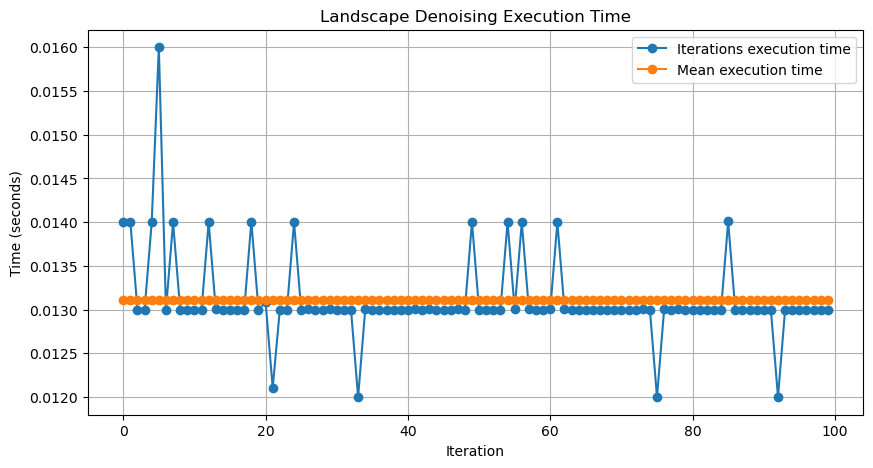

In [24]:
plot_performance()

In [66]:
plot_images()

NameError: name 'plot_images' is not defined

C:\Users\rss\AppData\Local\Temp\ipykernel_26060\944685891.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  center_shift = np.asarray(np.fft.fftshift(f_transform), np.float64)


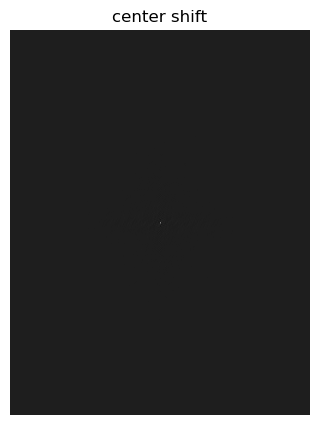

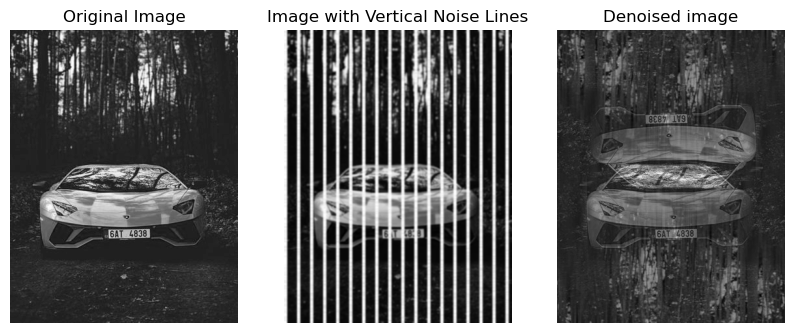

In [67]:
#noisy_img = add_smooth_vertical_noise(img, line_intensity=255, line_thickness=5, spacing=20, noise_variability=25, blur_kernel=(5, 5))
denoised_img = fourier_denoise(img, 4, 10)
# Display the noisy image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Image with Vertical Noise Lines')
plt.imshow(noisy_img, cmap='gray')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.title('Denoised image')
plt.imshow(denoised_img, cmap='gray')
plt.axis('off')


plt.show()

# Save the noisy image
#cv2.imwrite('noisy_image.png', noisy_img)